In [2]:
from finefood import preprocessing, utils
from keras.utils import np_utils
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import h5py
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package stopwords to /Users/joak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import re
import string
import numpy as np
from finefood import preprocessing, utils

In [4]:
path = "./data/Reviews.csv"

In [5]:
df = pd.read_csv(path).set_index("Id")

stemmer = SnowballStemmer('english')

def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    text = text.split()
    #stemmed_words = [stemmer.stem(word) for word in text]
    #text = " ".join(stemmed_words)

    return text

In [6]:
clean_texts = df['Text'].map(lambda x: preprocessing.clean_text(x))

In [71]:
text_lenghts = np.array([len(t) for t in clean_texts.values])

In [8]:
corpus, word_to_index, word_to_vec_map = utils.read_glove_vecs("./data/glove.6B.100d.txt")

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [10]:
MAX_NUM_WORDS = 20000

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(clean_texts)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(clean_texts)

print('Found %s unique tokens.' % len(word_index))


Found 105056 unique tokens.


In [11]:
tokenizer_vocab = {w for w, i in word_index.items() if i < MAX_NUM_WORDS}

In [52]:
print("Tokenizer vocabulary", len(tokenizer_vocab))
print("gloVe vocabulary", len(corpus))
print("Intersection", len(set(tokenizer_vocab).intersection(set(corpus))))
print("Difference", len(set(tokenizer_vocab).difference(set(corpus))))


Tokenizer vocabulary 19999
gloVe vocabulary 400000
Intersection 18588
Difference 1411


In [77]:
MAX_SEQUENCE_LENGTH = 400

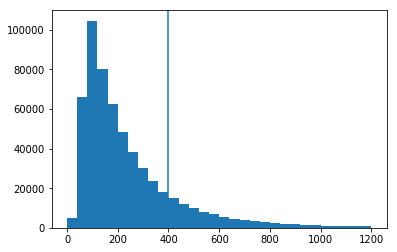

In [78]:
plt.hist(text_lenghts, 30, range=(0,1200))
plt.axvline(MAX_SEQUENCE_LENGTH)

In [84]:
print("Truncated texts %2.2f%%"%((text_lenghts>MAX_SEQUENCE_LENGTH).sum() / text_lenghts.size * 100))

Truncated texts 16.15%


In [85]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="pre", truncating="pre")
labels = to_categorical(np.asarray(df.Score))[:, 1:]
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (568454, 400)
Shape of label tensor: (568454, 5)


In [86]:
def rnd_embedding(word_to_vec_map):
    embeddings = np.array(list(word_to_vec_map.values()))
    means = embeddings.mean(axis=0)
    stds = embeddings.std(axis=0)
    def generator():
        return np.random.normal(means, stds)
    return generator

In [87]:
embedding_gen = rnd_embedding(word_to_vec_map)

In [88]:
embedding_gen().shape

(100,)

In [89]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((MAX_NUM_WORDS, 100))
for word, index in tokenizer.word_index.items():
    if index > MAX_NUM_WORDS - 1:
        continue
    else:
        embedding_vector = word_to_vec_map.get(word)
        if embedding_vector is None:
            embedding_vector = embedding_gen()
            word_to_vec_map[word] = embedding_vector
            
        embedding_matrix[index] = embedding_vector


In [90]:
embedding_matrix.shape

(20000, 100)

In [91]:
with h5py.File("./data/Reviews.h5", "w") as fp:
    fp.create_dataset("text_indices", data=data,  compression="gzip")
    fp["scores_oh"] = labels
    fp.create_dataset("embedding_matrix", data=embedding_matrix,  compression="gzip")

In [92]:
sorted_word_counts = pd.DataFrame(sorted(tokenizer.word_counts.items(), key=lambda e: e[1], reverse=True), columns=["word", "counts"]).set_index("word")
sorted_word_counts = sorted_word_counts[sorted_word_counts["counts"]!=1]

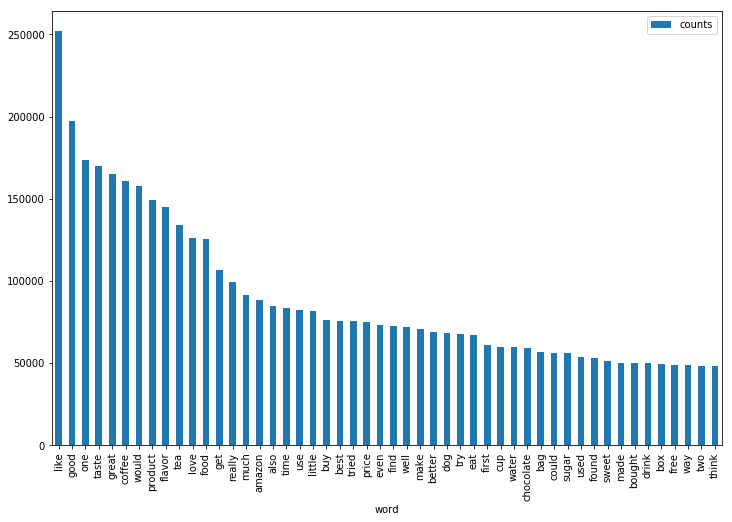

In [93]:
sorted_word_counts.iloc[:50].plot(kind="bar", figsize=(12,8))

In [94]:
difference = set(tokenizer_vocab).difference(set(corpus))

In [95]:
difference_word_counts = pd.DataFrame(sorted([(w,c) for w,c in tokenizer.word_counts.items() if w in difference], key=lambda e: e[1], reverse=True), columns=["word", "counts"]).set_index("word")

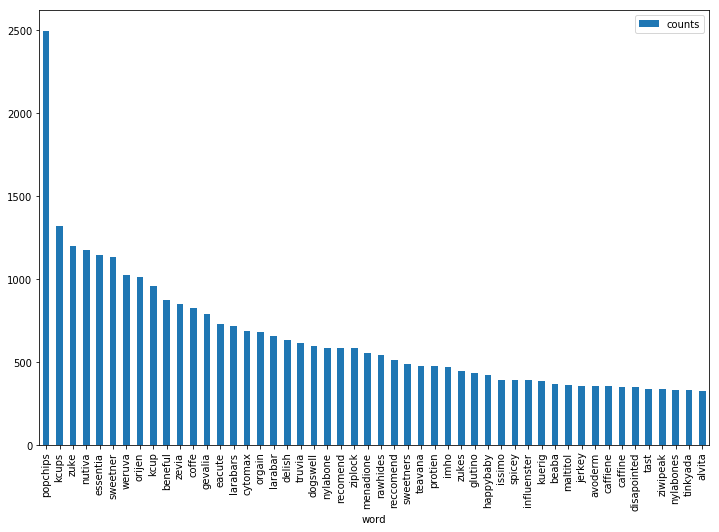

In [96]:
difference_word_counts.iloc[:50].plot(kind="bar", figsize=(12,8))